## Least Squares Monte Carlo Method (Longstaff-Schwartz)

Least Squares Monte Carlo method developd by Longstaff and Schwartz extends Monte-Carlo simulation to value options with early exercise features. It uses least squares regression to estimate the value of not exercising the point at each point in time.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

In [23]:
import warnings
warnings.filterwarnings('ignore')

**Calculate the price of American put option with the following parameters.**

In [24]:
S0 = 120
K =110
T = 0.8
r = 0.03
vol =0.3

In [25]:
def stock_df(paths,S0,T,r,vol,n=100):
    stock_table = np.empty((paths,n+1))
    t = np.array([i*T/n for i in range(0,n+1)])
    z = np.random.randn(paths,n)
    stock_table = np.ones((paths,1))*S0
    for i in range(n):
        stock_table = np.concatenate((stock_table,
                                      (stock_table[:,i]*np.exp((r-0.5*vol**2)*(T/n)+vol*z[:,i]*(T/n)**0.5)).reshape(paths,1)),
                                     axis=1)      
       
    stock_df = pd.DataFrame(data=stock_table,columns=t)
    stock_df.columns.name ='Time'
    stock_df.index.name ='Paths'
    return stock_df
    

In [26]:
s =stock_df(10000,S0,T,r,vol,n=100)

In [27]:
def cash_flow_df(stock_df,K,r,option_type=-1):
    cash_flow_df = stock_df.copy()
    cash_flow_df.iloc[:,-1] = np.maximum(option_type*(stock_df.iloc[:,-1]-K),0)
    
    for i in range(len(stock_df.columns)-2,-1,-1):
        exercise_value = np.maximum(option_type*(stock_df.iloc[:,i]-K),0)
        exercise_points = exercise_value>0
        
        discounted_cash_flow = cash_flow_df.iloc[:,i+1]*np.exp(-r*(stock_df.columns[i+1]-stock_df.columns[i]))
        
        
        holding_value = discounted_cash_flow
        
        if stock_df.iloc[:,i][exercise_points].count() !=0 :
            coeffs = np.polyfit(stock_df.iloc[:,i][exercise_points],
                                discounted_cash_flow[exercise_points],deg=2)
        
            
            holding_value[exercise_points] = (stock_df.iloc[:,i][exercise_points]**2)*coeffs[0]+ \
                                            stock_df.iloc[:,i][exercise_points]*coeffs[1]+ \
                                            coeffs[2]
        
        
        cash_flow_df.iloc[:,i] = np.maximum(exercise_value,holding_value)
    
    return cash_flow_df

In [28]:
c = cash_flow_df(s,K,r,option_type=-1)

In [29]:
american_montecarlo = np.mean(c[0])
print(f'The price of the American put option is {round(american_montecarlo,2)}')

The price of the American put option is 7.14


We can use control variate technique to reduce the variance in the estimate. For that, we need to calculate the value of European option using monte-carlo method.

In [30]:
european_montecarlo = np.mean(np.maximum(K-s.iloc[:,-1],0))*np.exp(-r*T)
print(f'The price of the European put option using Monte-Carlo is {round(european_montecarlo,2)}')

The price of the European put option using Monte-Carlo is 6.83


In [31]:
def blackscholes(S0,T,K,r,vol,call=1):
    d1 = (np.log(S0/K)+(r+0.5*vol**2)*(T))/(vol*T**0.5)
    d2 = d1-(vol*T**0.5)
    if call==1:
        price = S0*st.norm.cdf(d1)-K*np.exp(-r*T)*st.norm.cdf(d2)
    else:
        price = -S0*st.norm.cdf(-d1)+K*np.exp(-r*T)*st.norm.cdf(-d2)
    return price

In [32]:
black_scholes_put = blackscholes(S0,T,K,r,vol,call=-1)
print(f'The price of the European put option using black-scholes model is {round(black_scholes_put,2)}')

The price of the European put option using black-scholes model is 6.85


In [33]:
print(f'Using Control Variate technique, the price can be estimated as '\
      f'{round(black_scholes_put-european_montecarlo+american_montecarlo,2)}')

Using Control Variate technique, the price can be estimated as 7.16


**Comparing the method with a finite difference method (Crank-Nicholson Method) for different stock prices:**

In [34]:
class CrankNicholson():
    def __init__(self):
        pass
    
    def grid(self,NTS,T,Smax,NAS):
        s_values = [j*Smax/NAS for j in range(0,NAS+1)]
        t_values = [i*T/NTS for i in range(0,NTS+1)]
        grid = [np.zeros(NAS+1) for i in range(NTS+1)]
        return {'Time':t_values,'Stock':s_values,'Grid':grid}
    
    def CN_pms(self,s,ds,dt,r,vol):
        A = -r*s/(4*ds)+vol**2*s**2/(4*ds**2)
        B = -1/dt-vol**2*s**2/(2*ds**2)-r/2
        C = r*s/(4*ds)+vol**2*s**2/(4*ds**2)
        D = 1/dt-vol**2*s**2/(2*ds**2)-r/2
        return A,B,C,D
    
    def CN_matrix(self,s_values,ds,dt,r,vol):
        M=len(s_values)
        matrix_1 = np.zeros(shape=(M-2,M))
        matrix_2 = np.zeros(shape=(M-2,M))
        for j in range(1,M-1):
            A,B,C,D = self.CN_pms(s_values[j],ds,dt,r,vol)
            matrix_1[j-1,j-1] = A
            matrix_1[j-1,j] = B
            matrix_1[j-1,j+1] = C

            matrix_2[j-1,j-1] = A
            matrix_2[j-1,j] = D
            matrix_2[j-1,j+1] = C
        return matrix_1,matrix_2
    
    def CN_method(self,grid_dict,K,r,vol,call=1):
        v = grid_dict['Grid']
        s = grid_dict['Stock']
        t = grid_dict['Time']
        dt = t[1]-t[0]
        ds = s[1]-s[0]
        if call ==1:
            c =1
        else:
            c=-1
        payoff  = [np.maximum(c*(s[j]-K),0) for j in range(len(s))]
        v[-1] =payoff
        matrices =self.CN_matrix(s,ds,dt,r,vol)

        matrix_1 = matrices[0]
        matrix_2 = matrices[1]

        for i in range(len(t)-2,-1,-1):
            v[i][0] = np.maximum(c*(s[0]-K*np.exp(-r*(t[-1]-t[i]))),0)
            v[i][-1] = np.maximum(c*(s[-1]-K*np.exp(-r*(t[-1]-t[i]))),0)
            v2 = v[i+1]
            M_2 = np.matmul(matrix_2,v2)
            r_1 = matrix_1[:,0]*v[i][0]+matrix_1[:,-1]*v[i][-1]
            M_1 = matrix_1[:,1:len(s)-1]
            v[i][1:len(s)-1] = np.matmul(np.linalg.inv(M_1),-M_2-r_1)
            
            #early exercise
            v[i] =np.maximum(payoff,v[i])

        grid_dict['Grid'] = v

        g = pd.DataFrame(data = grid_dict['Grid'],index=grid_dict['Time'],columns=grid_dict['Stock'])
        g.index.name = 'Time'
        g.columns.name ='Stock Price'    

        return g

In [35]:
CN= CrankNicholson()
g = CN.grid(200,T,240,120)
CN_grid = CN.CN_method(g,K,r,vol,call=-1)

In [36]:
print(f'The price of the option using Finite Difference Method is {round(CN_grid.loc[0,S0],2)}')

The price of the option using Finite Difference Method is 6.97


We know that the finite difference method is more efficient as well as more accurate method in lower dimensions. But for higher dimensions, Least squares Monte Carlo method may be preferred.

Plotting the option price for different initial stock price values

In [37]:
Si = list(range(120,171,10))

In [38]:
LSMC_list= []

for i in Si:
    s_df = stock_df(10000,i,T,r,vol,n=100)
    c_i = cash_flow_df(s_df,K,r,option_type=-1)[0]
    LSMC_list.append(np.mean(c_i))

In [39]:
CN_list = [CN_grid.loc[0,i] for i in Si]

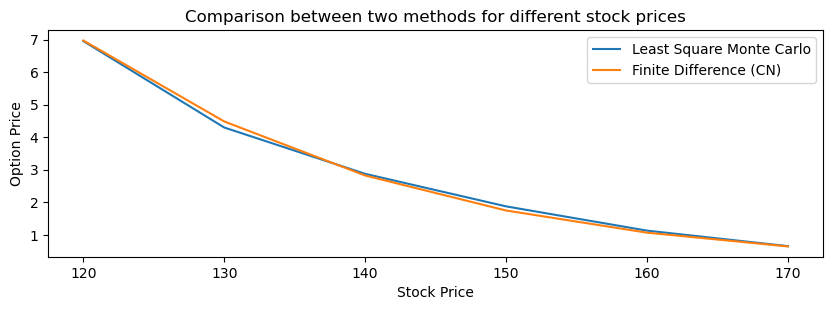

In [40]:
plt.figure(figsize=(10,3),dpi=100)
plt.plot(Si,LSMC_list,label='Least Square Monte Carlo')
plt.plot(Si,CN_list,label='Finite Difference (CN)')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Comparison between two methods for different stock prices')
plt.legend()

We could see that the two methods give almost similar results.